<font size="10" style="font-family: Computer Modern">
Wielowymiarowa iteracyjna metoda Newtona rozwiązywania równań nieliniowych
</font>

In [1]:
%%bash

cat > requirements.txt <<EOF
contourpy==1.1.1
cycler==0.12.1
fonttools==4.43.1
imageio==2.31.5
jax[cpu]==0.4.13
jaxlib==0.4.13
kiwisolver==1.4.5
lazy_loader==0.3
matplotlib==3.7.1
ml-dtypes==0.3.1
mnist==0.2.2
networkx==3.1
numpy==1.26.1
opt-einsum==3.3.0
packaging==23.2
Pillow==10.1.0
pyparsing==3.1.1
python-dateutil==2.8.2
scikit-image==0.22.0
scipy==1.11.3
six==1.16.0
tifffile==2023.9.26
tqdm==4.66.1
EOF

python3 -m pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 54.4 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.13-py3-none-any.whl size=1518704 sha256=f9b59d391d0dc5cbfa90e95ce13683018f67f91c8a569b70013c07f5210238b6
  Stored in directory: /root/.cache/pip/wheels/f3/7a/25/f297f69029b5e4064e4736a0c4b3996a44cc27781c120bcb99
Successfully bui

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.1 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.1 which is incompatible.


In [2]:
import numpy.typing as npt
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
import mnist
import skimage
import itertools
import functools
import logging
import random
import sys
import gc

from typing import Type
from jax import jacobian, grad
from tqdm import tqdm
from abc import ABC, abstractmethod
from dataclasses import dataclass
from collections import namedtuple

In [3]:
logging.getLogger("jax").setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.ERROR)

<font size="9" style="font-family: Computer Modern">
Sieć neuronowa z użyciem metody Newtona
</font>

In [4]:
def central_gradient(f):
    def func(ws):
        n = len(ws)
        eps = np.finfo(np.float32).eps ** 0.5
        diff = np.eye(n) * eps
        gradient = np.zeros(n)
        denom = 1. / (2. * eps)

        for i in range(n):
            gradient[i] = denom * (f(ws + diff[i]) - f(ws - diff[i]))

        return gradient
    return func

def central_hessian(f):
    def func(ws):
        n = len(ws)
        eps = np.finfo(np.float32).eps ** 0.5
        diff = np.eye(n) * eps
        J = np.zeros((n, n))
        denom = 1.0 / (4.0 * eps ** 2)
        for i in range(n):
            for j in range(n):
                J[i][j] = denom * (f(ws + diff[i] + diff[j])
                                    - f(ws + diff[i] - diff[j])
                                    - f(ws - diff[i] + diff[j])
                                    + f(ws - diff[i] - diff[j]))

        return J
    return func

In [5]:
Layer = namedtuple('Layer', 'into, out, activation, dropout_rate')
Weights = npt.NDArray[np.float32]
# LossFunction = Callable[[], np.float32]
# CostFunction = Callable[[npt.NDArray[np.float32]], np.float32]

@dataclass
class Metrics:
    accuracy: float
    precision: float
    recall: float

    @classmethod
    def get(cls, nn, X, Y, label_function):
        """
        label_function takes output of model and returns associated label
        """
        tp = 0
        tn = 0
        fp = 0
        fn = 0

        labels = label_function(nn.predict(X))
        for label, y in zip(labels, Y):
            if label != y:
                if label:
                    fp += 1
                else:
                    fn += 1
            else:
                if label:
                    tp += 1
                else:
                    tn += 1
        accuracy = float(tp + tn) / len(X)
        precision = float(tp) / (tp + fp)
        recall = float(tp) / (tp + fn)
        return cls(accuracy=accuracy, precision=precision, recall=recall)



class Optimizer(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def __call__(self, weigths, rate: float = 1.0):
        pass


class NN():
    def __init__(self, cost, layers):
        self.cost = cost
        self.layers = layers
        self.weights: Weights = self._initialize_weights()
        self.losses = []


    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + jnp.exp(-x))

    @staticmethod
    def ReLU(x):
        return jnp.where(x > 0, x, 0)

    def _initialize_weights(self):
        wsize = 0
        for layer in self.layers:
            inn = layer[0]
            out = layer[1]
            wsize += inn * out + out

        return np.random.uniform(low=-1.0, high=1.0, size=wsize).astype(np.float32)


    def weights_at(self, weights: Weights):
        skipped = 0
        for layer in self.layers:
            inn = layer[0]
            out = layer[1]
            biasize = layer[1]
            A = weights[skipped: skipped + inn * out]
            skipped += inn * out
            A = A.reshape((inn, out))
            b = weights[skipped: skipped + biasize]
            skipped += biasize

            yield A, b


    def _feed_forward(self, inp, weights: Weights, train=False):
        for ws, layer in zip(self.weights_at(weights), self.layers):
            A, b = ws
            fact = layer[2]
            inp = fact(inp @ A + b)
            dropout_rate = layer[3]
            if train and dropout_rate > 0:
                dropout_mask = np.random.uniform(low=0.0, high=1.0) > dropout_rate
                inp = inp * dropout_mask
        return inp

    def predict(self, inp):
        return self._feed_forward(inp, self.weights, train=False)


    def fit(self,
            X, Y, optimizer_class: Type[Optimizer],
            epochs: int = 1,
            batch_size: int = 1,
            rate: float = 1.0,
            rate_decrease: float = -1.0):

        self.losses = []
        self.calculate_and_log_loss(X, Y)


        for i in range(epochs):
            tqdm.write(f'epoch: {i + 1}/{epochs}')
            self.epoch(X, Y, optimizer_class,
                       batch_size=batch_size, rate=rate)

            self.calculate_and_log_loss(X, Y)
            if rate_decrease > 0:
                rate = rate * rate_decrease

    def calculate_and_log_loss(self, X, Y):
        loss = self.evaluate(X, Y)
        self.losses.append(loss)
        tqdm.write(f'cost: {loss}')


    def epoch(self,
              X, Y, optimizer_class: Type[Optimizer],
              batch_size: int = 1,
              rate: float = 1.0):

        Xbatches, Ybatches = self.batch_randomize_and_split(X, Y, batch_size)

        pbar = tqdm(zip(Xbatches, Ybatches), leave=True, total=len(Xbatches))
        for x, y in pbar:
            cost = functools.partial(self._costed, x=x, y=y)
            optimizer = optimizer_class(cost)
            self.weights = optimizer(self.weights, rate)
            gc.collect()
        pbar.close()

        self.dropout_scaling()

    def dropout_scaling(self):
        skipped = 0
        for layer in self.layers:
            dropout_rate = layer[3]
            inn = layer[0]
            out = layer[1]
            to = skipped + (inn + 1) * out
            const = 1 - dropout_rate
            self.weights = self.weights.at[skipped: to].multiply(const)


    def _costed(self, ws, x, y):
        output = self._feed_forward(x, ws, train=True)
        return self.cost(output, y)

    @staticmethod
    def mse(output, expected):
        return jnp.mean((output - expected) ** 2)

    def evaluate(self, X, Y):
        out = self.predict(X)
        return self.cost(out, Y)

    def batch_randomize_and_split(self, X, Y, batch_size):
        p = np.random.permutation(range(len(X)))
        X = X[p]
        Y = Y[p]
        Xbatches = self.batch_split(X, batch_size)
        Ybatches = self.batch_split(Y, batch_size)
        return Xbatches, Ybatches

    @staticmethod
    def batch_split(a, batch_size):
        n = len(a)
        batches_num = n // batch_size
        batches = [a[i * batch_size: (i + 1) * batch_size] for i in range(batches_num)]
        if n % batch_size != 0:
            batches.append(a[batches_num * batch_size: n])
        return  batches

    def plot_loss(self, ax, **kwargs):
        ax.set_title('Loss', fontsize=24)
        ax.set_xlabel('epoch', fontsize=16)
        ax.set_ylabel('loss', fontsize=16)
        ax.plot(self.losses, **kwargs)


class NewtonOptimizer(Optimizer, ABC):
    def __init__(self, cost):
        super().__init__()
        self.dcost = grad(cost)
        self.jac = jacobian(self.dcost)


    def __call__(self, weights: Weights, rate: float = 1.0):
        return self.qwickroot(weights, rate)

    def qwickroot(self, x0: np.ndarray, eps: float) -> np.ndarray:
        fx0 = self.dcost(x0)
        Df = self.jac(x0)
        Df = self._positivedefinitize(Df)
        Dfinv = self.inverse(Df)
        dk = Dfinv @ fx0
        x_next = x0 - eps * dk
        return x_next

    @abstractmethod
    def inverse(self, A):
        """ Matrix A can be assumed to be positive semi definite
        """

    def _positivedefinitize(self, A, beta=1e-3):
        """ It transform matrix to be positive definite, thus invertible
        Method adapted from:
        @Inbook{Nocedal2006,
                title="Line Search Methods",
                bookTitle="Numerical Optimization",
                year="2006",
                publisher="Springer New York",
                address="New York, NY",
                pages="30--65",
                isbn="978-0-387-40065-5",
                doi="10.1007/978-0-387-40065-5_3",
                url="https://doi.org/10.1007/978-0-387-40065-5_3"
        }
        """

        I = np.eye(len(A))
        mini = np.min(np.diagonal(A))
        t = 0.0
        if mini == 0.0:
            t = -mini + beta

        while True:
            try:
                L = np.linalg.cholesky(A + t * I)
            except np.linalg.LinAlgError:
                t = max(2 * t, beta)
            else:
                break
        return L

class ExactNewtonOptimizer(NewtonOptimizer):
    """ Computes exact jacobian inverse

    It tends to be faster for higher dimensions.
    """

    def inverse(self, A):
        return np.linalg.inv(A)

class InexactNewtonOptimizer(NewtonOptimizer):
    """ Computes jacobian pseudoinverse

    It tends to be faster for lower dimensions.
    """

    def inverse(self, A):
        try:
            return np.linalg.pinv(A)
        except np.linalg.LinAlgError:
            return np.linalg.inv(A)

class ExactAutoStepNewtonOptimizer(ExactNewtonOptimizer):
    def __call__(self, weights: Weights, rate: float = 1.0):
        return self.slowroot(weights)

    def slowroot(self, x0: npt.NDArray) -> npt.NDArray:
        fx0 = self.dcost(x0)
        hx0 = fx0.T @ fx0
        Df = self.jac(x0)
        Df = self._positivedefinitize(Df)
        Dfinv = self.inverse(Df)
        dk = Dfinv @ fx0

        gk = 1.0 / (jnp.linalg.norm(Dfinv) * jnp.linalg.norm(Df))

        Dh_norm = jnp.linalg.norm(2.0 * fx0.T @ Df)
        dk_norm = jnp.linalg.norm(dk)
        const = 0.25 * gk * dk_norm * Dh_norm

        for j in range(30):
            power = 0.5 ** j
            fxj = self.dcost(x0 - power * dk)
            hxj = fxj.T @ fxj
            dhx0 = hx0 - power * const
            if dhx0 - hxj >= -1e-7:
                break

        x_next = x0
        for i in range(0, j+1):
            xi = x0 - 0.5 ** i * dk
            fxn = self.dcost(xi)
            hxn = fxn.T @ fxn
            if hxn < hx0:
                fx0 = fxn
                hx0 = hxn
                x_next = xi
        return x_next




class AutoGradientOptimizer(Optimizer):
    def __init__(self, cost):
        super().__init__()
        self.dcost = grad(cost)

    def __call__(self, weights: Weights, rate: float = 1.0):

        dw = self.dcost(weights)
        return weights - rate * dw

class ForwardGradientOptimizer(Optimizer):
    def __init__(self, cost):
        super().__init__()
        self.cost = cost

    def __call__(self, weights: Weights, rate: float = 1.0):
        """
        Machine epsilon was set according to
        @incollection{numerical,
            author={Press, WH and Teukolsky, SA and Vetterling, WT and Flannery, BP},
            title={Numerical Recipes: The Art of Scientific Computing. 3rd ed},
            year={2007},
            chapter={5.7 Numerical Derivatives},
            pages={230},
            publisher={Cambridge University Press, Cambridge}
        }
        """
        eps = (np.finfo(np.float32).eps ** 0.5) * weights
        mineps = 1e1 * np.finfo(np.float32).eps
        eps = np.where(eps < mineps, mineps, eps)

        n = len(weights)
        I = np.eye(n)

        for i in range(n):
            dw = (self.cost(weights + I[i] * eps[i]) - self.cost(weights)) / eps[i]
            weights -= rate * I[i] * dw

        return weights

class PerVariableOptimizer(Optimizer):
    def __init__(self, cost):
        super().__init__()
        self.cost = cost

    def __call__(self, weights: Weights, rate: float = 1.0):
        n = len(weights)
        I = np.eye(n)
        for i in range(n):
            fx = self.cost(weights)
            dw = rate * I[i]
            fxe = self.cost(weights + dw)
            weights = weights - (fxe - fx) / rate

        return weights


<font size="6" style="font-family: Computer Modern">
Sieć neuronowa modelująca bitowy OR.
</font>

In [6]:
np.random.seed(1234)
random.seed(1234)

layers = [
    Layer(2, 1, NN.sigmoid, dropout_rate=0),
]

nn = NN(NN.mse, layers)

X = np.array(random.choices([np.array([0.0, 0.0]),
                np.array([0.0, 1.0]),
                np.array([1.0, 0.0]),
                np.array([1.0, 1.0])], k=50)
)
Y = np.array([[float(int(a[0]) | int(a[1]))] for a in X])

nn.fit(X, Y, InexactNewtonOptimizer, epochs=10, batch_size=10, rate=1.0)

cost: 0.3155706822872162
epoch: 1/10


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


cost: 0.09920070320367813
epoch: 2/10


100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


cost: 0.05841129273176193
epoch: 3/10


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


cost: 0.03677552938461304
epoch: 4/10


100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


cost: 0.02405356429517269
epoch: 5/10


100%|██████████| 5/5 [00:01<00:00,  3.98it/s]


cost: 0.01614859141409397
epoch: 6/10


100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


cost: 0.01187143288552761
epoch: 7/10


100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


cost: 0.00895601138472557
epoch: 8/10


100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


cost: 0.00678985146805644
epoch: 9/10


100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


cost: 0.00534164160490036
epoch: 10/10


100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

cost: 0.00428421888500452


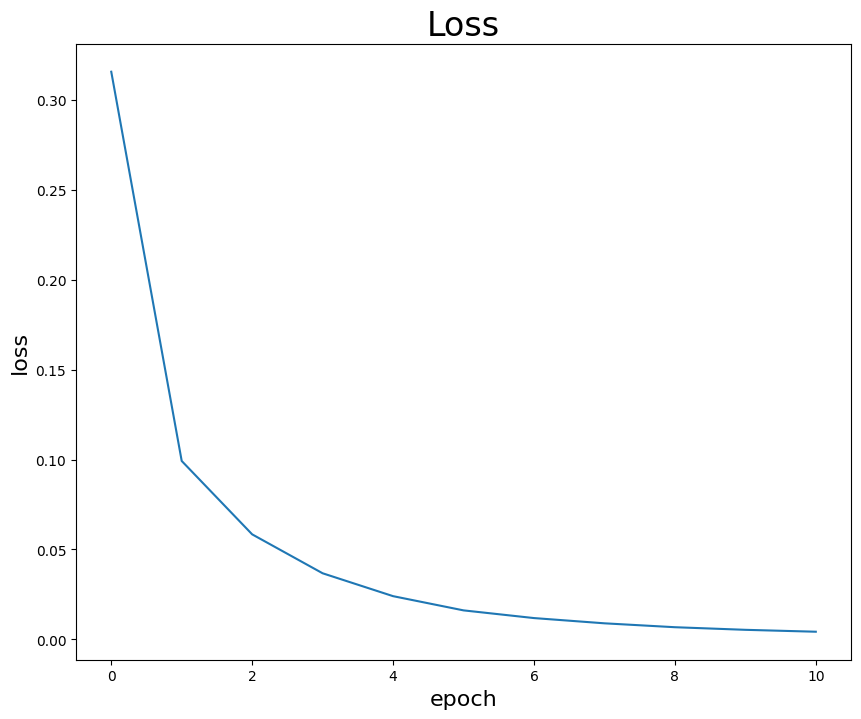

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), dpi=100)
nn.plot_loss(ax)

In [8]:
nn.weights

Array([ 5.642977 ,  5.462392 , -3.2570977], dtype=float32)

In [9]:
print(f'OR(0, 0) = {nn.predict(np.array([0.0, 0.0]))}')
print(f'OR(0, 1) = {nn.predict(np.array([0.0, 1.0]))}')
print(f'OR(1, 0) = {nn.predict(np.array([1.0, 0.0]))}')
print(f'OR(1, 1) = {nn.predict(np.array([1.0, 1.0]))}')

OR(0, 0) = [0.03707267]
OR(0, 1) = [0.90072393]
OR(1, 0) = [0.9157442]
OR(1, 1) = [0.99960977]


<font size="6" style="font-family: Computer Modern">
Sieć neuronowa modelująca bitowy XOR.
</font>

In [10]:
np.random.seed(1234)
random.seed(1234)

layers = [
    Layer(2, 2, NN.sigmoid, dropout_rate=0),
    Layer(2, 1, NN.sigmoid, dropout_rate=0)
]

nn = NN(NN.mse, layers)

X = np.array(random.choices([np.array([0.0, 0.0]),
                np.array([0.0, 1.0]),
                np.array([1.0, 0.0]),
                np.array([1.0, 1.0])], k=100)
)
Y = np.array([[float(int(a[0]) ^ int(a[1]))] for a in X])

nn.fit(X, Y, InexactNewtonOptimizer, epochs=75, batch_size=4, rate=1e-1)

cost: 0.32554933428764343
epoch: 1/75


100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


cost: 0.25789743661880493
epoch: 2/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


cost: 0.24833649396896362
epoch: 3/75


100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


cost: 0.24658870697021484
epoch: 4/75


100%|██████████| 25/25 [00:05<00:00,  4.91it/s]


cost: 0.24604648351669312
epoch: 5/75


100%|██████████| 25/25 [00:05<00:00,  4.33it/s]


cost: 0.24510705471038818
epoch: 6/75


100%|██████████| 25/25 [00:06<00:00,  4.00it/s]


cost: 0.2436605840921402
epoch: 7/75


100%|██████████| 25/25 [00:05<00:00,  4.40it/s]


cost: 0.2417382150888443
epoch: 8/75


100%|██████████| 25/25 [00:06<00:00,  3.76it/s]


cost: 0.24111366271972656
epoch: 9/75


100%|██████████| 25/25 [00:05<00:00,  4.62it/s]


cost: 0.24105632305145264
epoch: 10/75


100%|██████████| 25/25 [00:06<00:00,  3.94it/s]


cost: 0.24289509654045105
epoch: 11/75


100%|██████████| 25/25 [00:05<00:00,  4.43it/s]


cost: 0.2502272427082062
epoch: 12/75


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


cost: 0.24168036878108978
epoch: 13/75


100%|██████████| 25/25 [00:05<00:00,  4.24it/s]


cost: 0.23788970708847046
epoch: 14/75


100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


cost: 0.253035306930542
epoch: 15/75


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


cost: 0.24098235368728638
epoch: 16/75


100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


cost: 0.24271735548973083
epoch: 17/75


100%|██████████| 25/25 [00:07<00:00,  3.42it/s]


cost: 0.2454911768436432
epoch: 18/75


100%|██████████| 25/25 [00:05<00:00,  4.36it/s]


cost: 0.24468687176704407
epoch: 19/75


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


cost: 0.24452707171440125
epoch: 20/75


100%|██████████| 25/25 [00:05<00:00,  4.22it/s]


cost: 0.23876433074474335
epoch: 21/75


100%|██████████| 25/25 [00:05<00:00,  4.34it/s]


cost: 0.22486788034439087
epoch: 22/75


100%|██████████| 25/25 [00:06<00:00,  4.02it/s]


cost: 0.21926066279411316
epoch: 23/75


100%|██████████| 25/25 [00:05<00:00,  4.40it/s]


cost: 0.20937228202819824
epoch: 24/75


100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


cost: 0.20308764278888702
epoch: 25/75


100%|██████████| 25/25 [00:05<00:00,  4.79it/s]


cost: 0.18659313023090363
epoch: 26/75


100%|██████████| 25/25 [00:07<00:00,  3.56it/s]


cost: 0.18265318870544434
epoch: 27/75


100%|██████████| 25/25 [00:05<00:00,  4.86it/s]


cost: 0.15014533698558807
epoch: 28/75


100%|██████████| 25/25 [00:05<00:00,  4.27it/s]


cost: 0.16018174588680267
epoch: 29/75


100%|██████████| 25/25 [00:06<00:00,  3.93it/s]


cost: 0.1479552835226059
epoch: 30/75


100%|██████████| 25/25 [00:05<00:00,  4.64it/s]


cost: 0.17007526755332947
epoch: 31/75


100%|██████████| 25/25 [00:06<00:00,  3.73it/s]


cost: 0.13190962374210358
epoch: 32/75


100%|██████████| 25/25 [00:05<00:00,  4.43it/s]


cost: 0.10470215231180191
epoch: 33/75


100%|██████████| 25/25 [00:06<00:00,  3.71it/s]


cost: 0.10689587146043777
epoch: 34/75


100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


cost: 0.10198426991701126
epoch: 35/75


100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


cost: 0.10239707678556442
epoch: 36/75


100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


cost: 0.09761272370815277
epoch: 37/75


100%|██████████| 25/25 [00:05<00:00,  4.55it/s]


cost: 0.08851451426744461
epoch: 38/75


100%|██████████| 25/25 [00:06<00:00,  3.77it/s]


cost: 0.08176660537719727
epoch: 39/75


100%|██████████| 25/25 [00:05<00:00,  4.22it/s]


cost: 0.075362928211689
epoch: 40/75


100%|██████████| 25/25 [00:06<00:00,  3.79it/s]


cost: 0.07248811423778534
epoch: 41/75


100%|██████████| 25/25 [00:05<00:00,  4.31it/s]


cost: 0.07169719785451889
epoch: 42/75


100%|██████████| 25/25 [00:06<00:00,  3.62it/s]


cost: 0.07321228086948395
epoch: 43/75


100%|██████████| 25/25 [00:05<00:00,  4.54it/s]


cost: 0.05508166179060936
epoch: 44/75


100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


cost: 0.05759982764720917
epoch: 45/75


100%|██████████| 25/25 [00:06<00:00,  4.11it/s]


cost: 0.05463651195168495
epoch: 46/75


100%|██████████| 25/25 [00:06<00:00,  4.07it/s]


cost: 0.05066819116473198
epoch: 47/75


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


cost: 0.05197950080037117
epoch: 48/75


100%|██████████| 25/25 [00:05<00:00,  4.32it/s]


cost: 0.052923787385225296
epoch: 49/75


100%|██████████| 25/25 [00:06<00:00,  3.59it/s]


cost: 0.04861845821142197
epoch: 50/75


100%|██████████| 25/25 [00:05<00:00,  4.71it/s]


cost: 0.04459491744637489
epoch: 51/75


100%|██████████| 25/25 [00:07<00:00,  3.49it/s]


cost: 0.04291897639632225
epoch: 52/75


100%|██████████| 25/25 [00:05<00:00,  4.56it/s]


cost: 0.03746510297060013
epoch: 53/75


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


cost: 0.03852337598800659
epoch: 54/75


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


cost: 0.03973730653524399
epoch: 55/75


100%|██████████| 25/25 [00:06<00:00,  4.01it/s]


cost: 0.043221987783908844
epoch: 56/75


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


cost: 0.04242199659347534
epoch: 57/75


100%|██████████| 25/25 [00:05<00:00,  4.64it/s]


cost: 0.03652046248316765
epoch: 58/75


100%|██████████| 25/25 [00:06<00:00,  3.69it/s]


cost: 0.035409148782491684
epoch: 59/75


100%|██████████| 25/25 [00:05<00:00,  4.49it/s]


cost: 0.03567177802324295
epoch: 60/75


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


cost: 0.03013521060347557
epoch: 61/75


100%|██████████| 25/25 [00:05<00:00,  4.49it/s]


cost: 0.0335807278752327
epoch: 62/75


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


cost: 0.031593065708875656
epoch: 63/75


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


cost: 0.030867641791701317
epoch: 64/75


100%|██████████| 25/25 [00:05<00:00,  4.54it/s]


cost: 0.032003164291381836
epoch: 65/75


100%|██████████| 25/25 [00:06<00:00,  3.67it/s]


cost: 0.02804628573358059
epoch: 66/75


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


cost: 0.027760088443756104
epoch: 67/75


100%|██████████| 25/25 [00:07<00:00,  3.49it/s]


cost: 0.026506543159484863
epoch: 68/75


100%|██████████| 25/25 [00:05<00:00,  4.32it/s]


cost: 0.02532636560499668
epoch: 69/75


100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


cost: 0.030807707458734512
epoch: 70/75


100%|██████████| 25/25 [00:05<00:00,  4.96it/s]


cost: 0.026319412514567375
epoch: 71/75


100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


cost: 0.024870676919817924
epoch: 72/75


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


cost: 0.023316694423556328
epoch: 73/75


100%|██████████| 25/25 [00:06<00:00,  4.02it/s]


cost: 0.024548878893256187
epoch: 74/75


100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


cost: 0.0217891838401556
epoch: 75/75


100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

cost: 0.02333875559270382


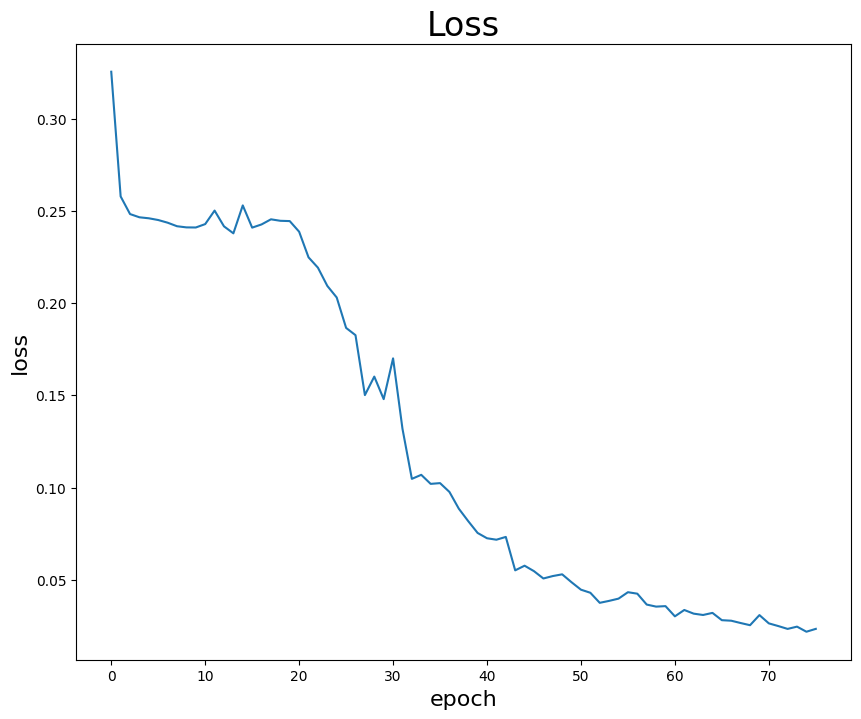

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), dpi=100)
nn.plot_loss(ax)

In [12]:
nn.weights

Array([  0.6147471 ,   5.8640404 ,   0.44441774,   5.016055  ,
        -0.86072874,  -1.5309542 , -25.316517  ,   9.259691  ,
         3.0597072 ], dtype=float32)

In [13]:
print(f'XOR(0, 0) = {nn.predict(np.array([0.0, 0.0]))}')
print(f'XOR(0, 1) = {nn.predict(np.array([0.0, 1.0]))}')
print(f'XOR(1, 0) = {nn.predict(np.array([1.0, 0.0]))}')
print(f'XOR(1, 1) = {nn.predict(np.array([1.0, 1.0]))}')

XOR(0, 0) = [0.05640381]
XOR(0, 1) = [0.8790267]
XOR(1, 0) = [0.74842125]
XOR(1, 1) = [0.1691746]


<font size="6" style="font-family: Computer Modern">
MNIST
</font>

In [14]:
train_size = 2500
test_size = 1000
digits = mnist.train_images()[:train_size] / 255.
labels = mnist.train_labels()[:train_size]
digits_test = mnist.test_images()[:test_size] / 255.
labels_test = mnist.test_labels()[:test_size]

5

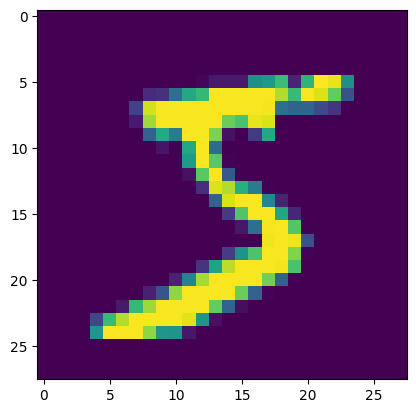

In [15]:
plt.imshow(digits[0]);
labels[0]

In [16]:
def scale_input(X):
    return np.array([skimage.transform.rescale(x, 0.25, anti_aliasing=False, preserve_range=True) for x in X])

def flatten_input(X):
    n = X.shape[0]
    return X.reshape((n, -1)).astype(np.float64)

def translate_input(X):
    return X - 0.5

def prepare_input(X):
    return translate_input(flatten_input(scale_input(X)))

def prepare_labels(Y):
    return np.array([[y % 2] for y in Y]).astype(np.float64)

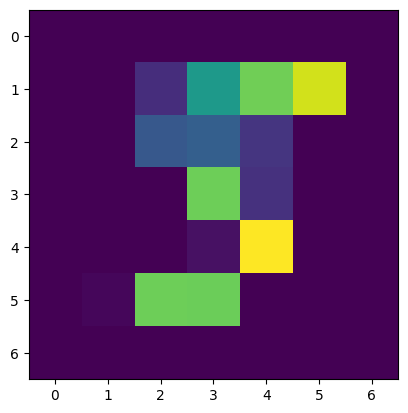

In [17]:
digits7x7 = np.array([skimage.transform.rescale(digit, 0.25, anti_aliasing=False, preserve_range=True) for digit in digits])
plt.imshow(digits7x7[0]);

In [18]:
np.random.seed(1234)
random.seed(1234)

X = prepare_input(digits)
Y = prepare_labels(labels)

layers = [
    Layer(49, 21, NN.ReLU, dropout_rate=0),
    Layer(21, 7,  NN.ReLU, dropout_rate=0),
    Layer(7, 1, NN.sigmoid, dropout_rate=0),
]

nn = NN(NN.mse, layers)
nn.fit(X, Y, ExactNewtonOptimizer, epochs=100, batch_size=100, rate=2.4e-1, rate_decrease=0.98)

cost: 0.3106206953525543
epoch: 1/100


100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


cost: 0.20124156773090363
epoch: 2/100


100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


cost: 0.1658424586057663
epoch: 3/100


100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


cost: 0.14321501553058624
epoch: 4/100


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


cost: 0.13154451549053192
epoch: 5/100


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


cost: 0.12237922102212906
epoch: 6/100


100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


cost: 0.11815483123064041
epoch: 7/100


100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


cost: 0.11520734429359436
epoch: 8/100


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


cost: 0.11205873638391495
epoch: 9/100


100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


cost: 0.11067880690097809
epoch: 10/100


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


cost: 0.10981371998786926
epoch: 11/100


100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


cost: 0.10588166117668152
epoch: 12/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.1042938083410263
epoch: 13/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.10329239070415497
epoch: 14/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.10350799560546875
epoch: 15/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.10231010615825653
epoch: 16/100


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


cost: 0.10144617408514023
epoch: 17/100


100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


cost: 0.10263488441705704
epoch: 18/100


100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


cost: 0.09943030774593353
epoch: 19/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.09940259158611298
epoch: 20/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.09681230783462524
epoch: 21/100


100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


cost: 0.09765830636024475
epoch: 22/100


100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


cost: 0.09534062445163727
epoch: 23/100


100%|██████████| 25/25 [00:27<00:00,  1.12s/it]


cost: 0.09574421495199203
epoch: 24/100


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


cost: 0.09842514246702194
epoch: 25/100


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


cost: 0.09488847106695175
epoch: 26/100


100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


cost: 0.09331998974084854
epoch: 27/100


100%|██████████| 25/25 [00:29<00:00,  1.16s/it]


cost: 0.09450292587280273
epoch: 28/100


100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


cost: 0.09429692476987839
epoch: 29/100


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


cost: 0.09410262107849121
epoch: 30/100


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


cost: 0.09294530749320984
epoch: 31/100


100%|██████████| 25/25 [00:27<00:00,  1.12s/it]


cost: 0.09279650449752808
epoch: 32/100


100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


cost: 0.09074129164218903
epoch: 33/100


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


cost: 0.09029806405305862
epoch: 34/100


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


cost: 0.09003135561943054
epoch: 35/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.09237290173768997
epoch: 36/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.09004620462656021
epoch: 37/100


100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


cost: 0.0894441232085228
epoch: 38/100


100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


cost: 0.08905281871557236
epoch: 39/100


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


cost: 0.08841671049594879
epoch: 40/100


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


cost: 0.08839071542024612
epoch: 41/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.09528234601020813
epoch: 42/100


100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


cost: 0.09066025912761688
epoch: 43/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.08683996647596359
epoch: 44/100


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


cost: 0.08817842602729797
epoch: 45/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.08625549077987671
epoch: 46/100


100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


cost: 0.08814460039138794
epoch: 47/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.08582641184329987
epoch: 48/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.08623703569173813
epoch: 49/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.08640782535076141
epoch: 50/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.0860888659954071
epoch: 51/100


100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


cost: 0.08446229249238968
epoch: 52/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.08431660383939743
epoch: 53/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.08611619472503662
epoch: 54/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.08327262848615646
epoch: 55/100


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


cost: 0.08413853496313095
epoch: 56/100


100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


cost: 0.08364008367061615
epoch: 57/100


100%|██████████| 25/25 [00:29<00:00,  1.16s/it]


cost: 0.08315952867269516
epoch: 58/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.08260326087474823
epoch: 59/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.08223887532949448
epoch: 60/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.08224260807037354
epoch: 61/100


100%|██████████| 25/25 [00:27<00:00,  1.12s/it]


cost: 0.08169759809970856
epoch: 62/100


100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


cost: 0.08207028359174728
epoch: 63/100


100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


cost: 0.08141763508319855
epoch: 64/100


100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


cost: 0.08075368404388428
epoch: 65/100


100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


cost: 0.08242882043123245
epoch: 66/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.08074983954429626
epoch: 67/100


100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


cost: 0.08694882690906525
epoch: 68/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.08169110864400864
epoch: 69/100


100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


cost: 0.08148109167814255
epoch: 70/100


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


cost: 0.0812239870429039
epoch: 71/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.08038762211799622
epoch: 72/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.08008107542991638
epoch: 73/100


100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


cost: 0.0798124149441719
epoch: 74/100


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


cost: 0.07966969162225723
epoch: 75/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.08003072440624237
epoch: 76/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.07921777665615082
epoch: 77/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.079700767993927
epoch: 78/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.07961375266313553
epoch: 79/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.08031349629163742
epoch: 80/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.07994988560676575
epoch: 81/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.07867524772882462
epoch: 82/100


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


cost: 0.07948791235685349
epoch: 83/100


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


cost: 0.07858894020318985
epoch: 84/100


100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


cost: 0.07820955663919449
epoch: 85/100


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


cost: 0.07779610902070999
epoch: 86/100


100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


cost: 0.07828951627016068
epoch: 87/100


100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


cost: 0.07815033197402954
epoch: 88/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.07761520892381668
epoch: 89/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.07770758122205734
epoch: 90/100


100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


cost: 0.07749898731708527
epoch: 91/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.07696548849344254
epoch: 92/100


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


cost: 0.07684945315122604
epoch: 93/100


100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


cost: 0.07697033137083054
epoch: 94/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.07761792093515396
epoch: 95/100


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


cost: 0.07666235417127609
epoch: 96/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.07629740983247757
epoch: 97/100


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


cost: 0.07620465010404587
epoch: 98/100


100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


cost: 0.07602005451917648
epoch: 99/100


100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


cost: 0.07586434483528137
epoch: 100/100


100%|██████████| 25/25 [00:28<00:00,  1.14s/it]

cost: 0.07578551024198532


In [19]:
nn.weights

Array([-0.83071226, -0.07747738, -0.22908194, ...,  0.29265362,
        0.6964391 ,  0.3570348 ], dtype=float32)

Bezpośrednie testy: Wytrenowana sieć rozpoznaje parzyste 0 i nieparzystą 5.

Array([[0.02593087]], dtype=float32)

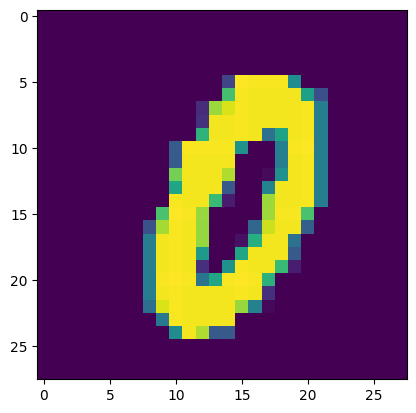

In [20]:
idx = 34
plt.imshow(digits[idx])
inp = np.array([digits7x7[idx].reshape(-1) - 0.5])
nn.predict(inp)

Array([[0.9557671]], dtype=float32)

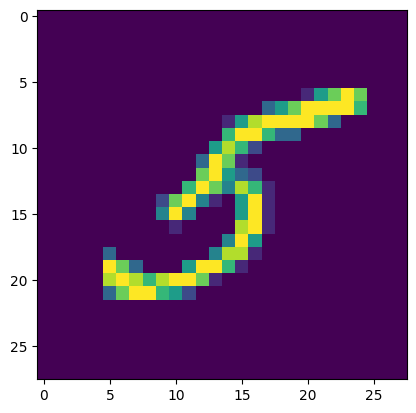

In [21]:
idx = 35
plt.imshow(digits[idx])
inp = np.array([digits7x7[idx].reshape(-1) - 0.5])
nn.predict(inp)

In [22]:
Xtest = prepare_input(digits_test)
Ytest = prepare_labels(labels_test)

nn.evaluate(Xtest, Ytest)

Array(0.11881187, dtype=float32)

In [23]:
Metrics.get(nn, Xtest, Ytest, label_function=lambda x: x > 0.5)

Metrics(accuracy=0.84, precision=0.8238532110091743, recall=0.8752436647173489)

<font size="6" style="font-family: Computer Modern">
    
Porównanie ze spadkiem wzdłuż gradientu.
</font>

In [24]:
np.random.seed(1234)
random.seed(1234)

X = prepare_input(digits)
Y = prepare_labels(labels)

layers = [
    (49, 21, NN.ReLU, 0),
    (21, 7, NN.ReLU, 0),
    (7, 1, NN.sigmoid, 0),
]

gnn = NN(NN.mse, layers)
gnn.fit(X, Y, AutoGradientOptimizer, epochs=100, batch_size=100, rate=2.4e-1, rate_decrease=0.98)

cost: 0.3106206953525543
epoch: 1/100


100%|██████████| 25/25 [00:05<00:00,  4.64it/s]


cost: 0.22419953346252441
epoch: 2/100


100%|██████████| 25/25 [00:04<00:00,  5.18it/s]


cost: 0.20187731087207794
epoch: 3/100


100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


cost: 0.19026702642440796
epoch: 4/100


100%|██████████| 25/25 [00:04<00:00,  5.33it/s]


cost: 0.17840279638767242
epoch: 5/100


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


cost: 0.17019079625606537
epoch: 6/100


100%|██████████| 25/25 [00:04<00:00,  5.69it/s]


cost: 0.1605299562215805
epoch: 7/100


100%|██████████| 25/25 [00:05<00:00,  4.29it/s]


cost: 0.15445798635482788
epoch: 8/100


100%|██████████| 25/25 [00:04<00:00,  5.77it/s]


cost: 0.14847539365291595
epoch: 9/100


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


cost: 0.1436203420162201
epoch: 10/100


100%|██████████| 25/25 [00:06<00:00,  4.02it/s]


cost: 0.13889841735363007
epoch: 11/100


100%|██████████| 25/25 [00:05<00:00,  4.98it/s]


cost: 0.1336129903793335
epoch: 12/100


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


cost: 0.13084200024604797
epoch: 13/100


100%|██████████| 25/25 [00:05<00:00,  4.50it/s]


cost: 0.12752510607242584
epoch: 14/100


100%|██████████| 25/25 [00:05<00:00,  4.91it/s]


cost: 0.1252504140138626
epoch: 15/100


100%|██████████| 25/25 [00:06<00:00,  3.96it/s]


cost: 0.12319782376289368
epoch: 16/100


100%|██████████| 25/25 [00:04<00:00,  5.94it/s]


cost: 0.12193366140127182
epoch: 17/100


100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


cost: 0.12011713534593582
epoch: 18/100


100%|██████████| 25/25 [00:05<00:00,  4.40it/s]


cost: 0.11844295263290405
epoch: 19/100


100%|██████████| 25/25 [00:04<00:00,  5.17it/s]


cost: 0.11745569854974747
epoch: 20/100


100%|██████████| 25/25 [00:04<00:00,  5.14it/s]


cost: 0.11614973843097687
epoch: 21/100


100%|██████████| 25/25 [00:05<00:00,  4.23it/s]


cost: 0.12496768683195114
epoch: 22/100


100%|██████████| 25/25 [00:04<00:00,  5.19it/s]


cost: 0.11437481641769409
epoch: 23/100


100%|██████████| 25/25 [00:05<00:00,  4.24it/s]


cost: 0.11486437916755676
epoch: 24/100


100%|██████████| 25/25 [00:04<00:00,  5.23it/s]


cost: 0.11280515044927597
epoch: 25/100


100%|██████████| 25/25 [00:05<00:00,  4.93it/s]


cost: 0.11457426100969315
epoch: 26/100


100%|██████████| 25/25 [00:05<00:00,  4.50it/s]


cost: 0.11146248131990433
epoch: 27/100


100%|██████████| 25/25 [00:04<00:00,  5.59it/s]


cost: 0.11065673828125
epoch: 28/100


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


cost: 0.11126101016998291
epoch: 29/100


100%|██████████| 25/25 [00:05<00:00,  4.34it/s]


cost: 0.11112368851900101
epoch: 30/100


100%|██████████| 25/25 [00:04<00:00,  5.23it/s]


cost: 0.11167687922716141
epoch: 31/100


100%|██████████| 25/25 [00:05<00:00,  4.67it/s]


cost: 0.10932421684265137
epoch: 32/100


100%|██████████| 25/25 [00:05<00:00,  4.93it/s]


cost: 0.10890372097492218
epoch: 33/100


100%|██████████| 25/25 [00:04<00:00,  6.06it/s]


cost: 0.10832491517066956
epoch: 34/100


100%|██████████| 25/25 [00:05<00:00,  4.66it/s]


cost: 0.10717523843050003
epoch: 35/100


100%|██████████| 25/25 [00:05<00:00,  4.99it/s]


cost: 0.10779660195112228
epoch: 36/100


100%|██████████| 25/25 [00:04<00:00,  5.31it/s]


cost: 0.10626930743455887
epoch: 37/100


100%|██████████| 25/25 [00:06<00:00,  4.11it/s]


cost: 0.1056770384311676
epoch: 38/100


100%|██████████| 25/25 [00:04<00:00,  5.18it/s]


cost: 0.10526235401630402
epoch: 39/100


100%|██████████| 25/25 [00:05<00:00,  4.72it/s]


cost: 0.10487050563097
epoch: 40/100


100%|██████████| 25/25 [00:04<00:00,  5.03it/s]


cost: 0.10421755164861679
epoch: 41/100


100%|██████████| 25/25 [00:04<00:00,  5.03it/s]


cost: 0.10385226458311081
epoch: 42/100


100%|██████████| 25/25 [00:05<00:00,  4.31it/s]


cost: 0.10428775101900101
epoch: 43/100


100%|██████████| 25/25 [00:04<00:00,  5.19it/s]


cost: 0.10304223001003265
epoch: 44/100


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


cost: 0.10280728340148926
epoch: 45/100


100%|██████████| 25/25 [00:04<00:00,  5.04it/s]


cost: 0.10244298726320267
epoch: 46/100


100%|██████████| 25/25 [00:04<00:00,  5.41it/s]


cost: 0.1031707376241684
epoch: 47/100


100%|██████████| 25/25 [00:05<00:00,  4.80it/s]


cost: 0.1022576242685318
epoch: 48/100


100%|██████████| 25/25 [00:06<00:00,  3.94it/s]


cost: 0.101748988032341
epoch: 49/100


100%|██████████| 25/25 [00:04<00:00,  5.46it/s]


cost: 0.10365307331085205
epoch: 50/100


100%|██████████| 25/25 [00:05<00:00,  4.47it/s]


cost: 0.10159153491258621
epoch: 51/100


100%|██████████| 25/25 [00:05<00:00,  4.79it/s]


cost: 0.10049193352460861
epoch: 52/100


100%|██████████| 25/25 [00:04<00:00,  5.18it/s]


cost: 0.09986963123083115
epoch: 53/100


100%|██████████| 25/25 [00:05<00:00,  4.85it/s]


cost: 0.09959593415260315
epoch: 54/100


100%|██████████| 25/25 [00:05<00:00,  4.98it/s]


cost: 0.09951192140579224
epoch: 55/100


100%|██████████| 25/25 [00:05<00:00,  4.87it/s]


cost: 0.0988384410738945
epoch: 56/100


100%|██████████| 25/25 [00:06<00:00,  4.00it/s]


cost: 0.10054156184196472
epoch: 57/100


100%|██████████| 25/25 [00:04<00:00,  5.27it/s]


cost: 0.09831037372350693
epoch: 58/100


100%|██████████| 25/25 [00:05<00:00,  4.71it/s]


cost: 0.09807825088500977
epoch: 59/100


100%|██████████| 25/25 [00:05<00:00,  4.51it/s]


cost: 0.09784853458404541
epoch: 60/100


100%|██████████| 25/25 [00:04<00:00,  5.71it/s]


cost: 0.09755661338567734
epoch: 61/100


100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


cost: 0.09737133234739304
epoch: 62/100


100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


cost: 0.09802331030368805
epoch: 63/100


100%|██████████| 25/25 [00:04<00:00,  5.28it/s]


cost: 0.09717079252004623
epoch: 64/100


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


cost: 0.09676376730203629
epoch: 65/100


100%|██████████| 25/25 [00:04<00:00,  5.18it/s]


cost: 0.09654677659273148
epoch: 66/100


100%|██████████| 25/25 [00:05<00:00,  4.79it/s]


cost: 0.09701339155435562
epoch: 67/100


100%|██████████| 25/25 [00:05<00:00,  4.41it/s]


cost: 0.09600085765123367
epoch: 68/100


100%|██████████| 25/25 [00:04<00:00,  5.23it/s]


cost: 0.09626869857311249
epoch: 69/100


100%|██████████| 25/25 [00:06<00:00,  4.11it/s]


cost: 0.09571632742881775
epoch: 70/100


100%|██████████| 25/25 [00:04<00:00,  5.27it/s]


cost: 0.09626098722219467
epoch: 71/100


100%|██████████| 25/25 [00:05<00:00,  4.80it/s]


cost: 0.0952223464846611
epoch: 72/100


100%|██████████| 25/25 [00:05<00:00,  4.52it/s]


cost: 0.09513916075229645
epoch: 73/100


100%|██████████| 25/25 [00:04<00:00,  5.32it/s]


cost: 0.09486372023820877
epoch: 74/100


100%|██████████| 25/25 [00:06<00:00,  4.10it/s]


cost: 0.09480495005846024
epoch: 75/100


100%|██████████| 25/25 [00:05<00:00,  4.67it/s]


cost: 0.09479336440563202
epoch: 76/100


100%|██████████| 25/25 [00:04<00:00,  5.59it/s]


cost: 0.09475076198577881
epoch: 77/100


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


cost: 0.09467824548482895
epoch: 78/100


100%|██████████| 25/25 [00:04<00:00,  5.52it/s]


cost: 0.09410953521728516
epoch: 79/100


100%|██████████| 25/25 [00:05<00:00,  4.71it/s]


cost: 0.09395693987607956
epoch: 80/100


100%|██████████| 25/25 [00:05<00:00,  4.29it/s]


cost: 0.09382569789886475
epoch: 81/100


100%|██████████| 25/25 [00:04<00:00,  5.82it/s]


cost: 0.09376952797174454
epoch: 82/100


100%|██████████| 25/25 [00:05<00:00,  4.64it/s]


cost: 0.09362064301967621
epoch: 83/100


100%|██████████| 25/25 [00:05<00:00,  4.93it/s]


cost: 0.09346719086170197
epoch: 84/100


100%|██████████| 25/25 [00:04<00:00,  6.04it/s]


cost: 0.09348493069410324
epoch: 85/100


100%|██████████| 25/25 [00:06<00:00,  4.03it/s]


cost: 0.09312054514884949
epoch: 86/100


100%|██████████| 25/25 [00:05<00:00,  4.94it/s]


cost: 0.09324400871992111
epoch: 87/100


100%|██████████| 25/25 [00:04<00:00,  5.22it/s]


cost: 0.09287995100021362
epoch: 88/100


100%|██████████| 25/25 [00:05<00:00,  4.71it/s]


cost: 0.09277550876140594
epoch: 89/100


100%|██████████| 25/25 [00:04<00:00,  5.46it/s]


cost: 0.09268288314342499
epoch: 90/100


100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


cost: 0.09255772083997726
epoch: 91/100


100%|██████████| 25/25 [00:05<00:00,  4.49it/s]


cost: 0.0927637591958046
epoch: 92/100


100%|██████████| 25/25 [00:04<00:00,  5.51it/s]


cost: 0.09232863783836365
epoch: 93/100


100%|██████████| 25/25 [00:04<00:00,  5.80it/s]


cost: 0.09224066138267517
epoch: 94/100


100%|██████████| 25/25 [00:05<00:00,  4.34it/s]


cost: 0.09235208481550217
epoch: 95/100


100%|██████████| 25/25 [00:04<00:00,  5.33it/s]


cost: 0.09220940619707108
epoch: 96/100


100%|██████████| 25/25 [00:05<00:00,  4.85it/s]


cost: 0.09185441583395004
epoch: 97/100


100%|██████████| 25/25 [00:04<00:00,  5.17it/s]


cost: 0.09176995605230331
epoch: 98/100


100%|██████████| 25/25 [00:04<00:00,  5.33it/s]


cost: 0.09178121387958527
epoch: 99/100


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


cost: 0.09156642854213715
epoch: 100/100


100%|██████████| 25/25 [00:04<00:00,  5.86it/s]

cost: 0.09150075167417526


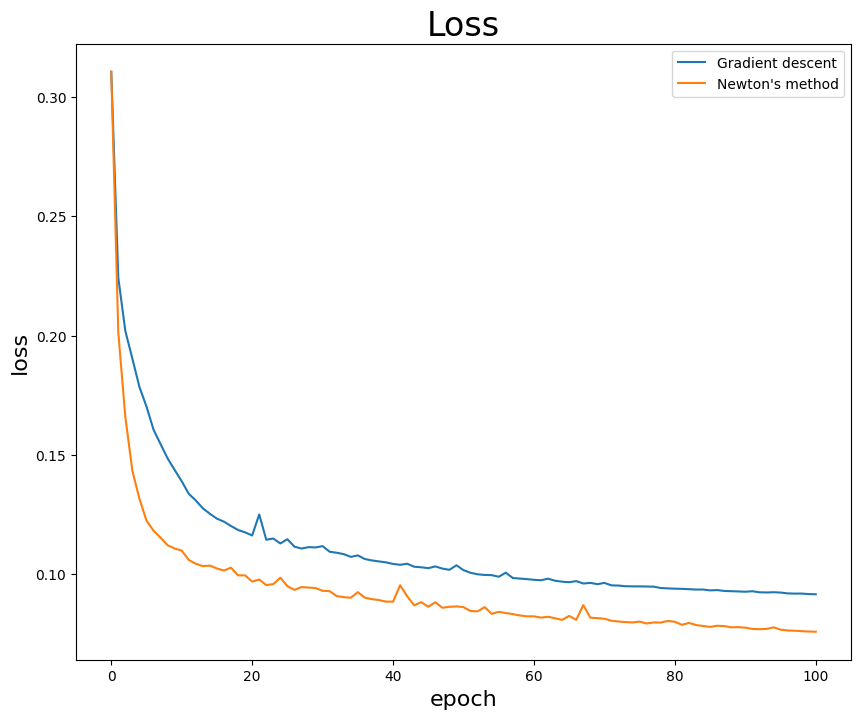

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), dpi=100)
gnn.plot_loss(ax, label='Gradient descent')
nn.plot_loss(ax, label="Newton's method")
ax.legend()

In [26]:
Metrics.get(gnn, Xtest, Ytest, label_function=lambda x: x > 0.5)

Metrics(accuracy=0.835, precision=0.8508064516129032, recall=0.8226120857699805)

<font size="5" style="font-family: Computer Modern">
    
Spadek wzdłuż gradientu jest około 5 razy szybszy od metody Newtona pod względem rzeczywistego czasu uczenia. Jest tak z uwagi na konieczność odwracania macierzy w metodzie Newtona, skaluje się ona znacznie gorzej wraz z rosnącą liczbą parametrów, więc wraz ze stopniem skomplikowania sieci dysproporcja czasów będzie się zwiększać na niekorzyść metody Newtona. Natomiast spadek wzdłuż gradientu zbiega wolniej w przeliczeniu na spadek wartości funkcji straty na jedną epokę. Niestety osiąganie niskich wartości funkcji straty na zbiorze treningowym może nie być opłacalne z uwagi na nadmierne dopasowanie modelu do danych i zmniejszone możliwości generalizacji na danych niezaobserwowanych.
</font>